# Tutorial for Chinese Sentiment analysis with hotel review data
## Dependencies

Python 3.5, numpy, pickle, keras, tensorflow, [jieba](https://github.com/fxsjy/jieba)

## Optional for plotting

pylab, scipy


In [46]:
from os import listdir
from os.path import isfile, join
import jieba
import codecs
from langconv import * # convert Traditional Chinese characters to Simplified Chinese characters
import pickle
import random

from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import GRU
from keras.preprocessing.text import Tokenizer
from keras.layers.core import Dense
#from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import TensorBoard

## Helper function to pickle and load stuff

In [47]:

def __pickleStuff(filename, stuff):
    save_stuff = open(filename, "wb")
    pickle.dump(stuff, save_stuff)
    save_stuff.close()
def __loadStuff(filename):
    saved_stuff = open(filename,"rb")
    stuff = pickle.load(saved_stuff)
    saved_stuff.close()
    return stuff

## Get lists of files, positive and negative files

In [48]:
dataBaseDirPos = "./data/ChnSentiCorp_htl_ba_6000/pos/"
dataBaseDirNeg = "./data/ChnSentiCorp_htl_ba_6000/neg/"
positiveFiles = [dataBaseDirPos + f for f in listdir(dataBaseDirPos) if isfile(join(dataBaseDirPos, f))]
negativeFiles = [dataBaseDirNeg + f for f in listdir(dataBaseDirNeg) if isfile(join(dataBaseDirNeg, f))]

## Show length of samples

In [49]:
print(len(positiveFiles))
print(len(negativeFiles))

2916
3000


## Have a look at what's in a file(one hotel review)

In [50]:
filename = positiveFiles[0]
with codecs.open(filename, "r") as doc_file:
    text=doc_file.read()
    print(text)

距离川沙公路较近,但是公交指示不对,如果是"蔡陆线"的话,会非常麻烦.建议用别的路线.房间较为简单.






## Test removing stop words
Demo what it looks like to tokenize the sentence and remove stop words.

In [51]:
filename = positiveFiles[110]
with codecs.open(filename, "r") as doc_file:
    text=doc_file.read()
    text = text.replace("\n", "")
    text = text.replace("\r", "")
print("==Orginal==:\n\r{}".format(text))
    
stopwords = [ line.rstrip() for line in codecs.open('./data/chinese_stop_words.txt',"r", encoding="utf-8") ]
seg_list = jieba.cut(text, cut_all=False)
final =[]
seg_list = list(seg_list)
for seg in seg_list:
    if seg not in stopwords:
        final.append(seg)
print("==Tokenized==\tToken count:{}\n\r{}".format(len(seg_list)," ".join(seg_list)))
print("==Stop Words Removed==\tToken count:{}\n\r{}".format(len(final)," ".join(final)))


==Orginal==:
一年多没来过了，再来住，感觉不错，旧瓶装了新酒，标准房里面的设施基本上都换新了，到处都见到笑脸，看来这里才真正是买方市场，我喜欢员工“巴结”客人的感觉，给他个满分。
==Tokenized==	Token count:56
一年 多 没来 过 了 ， 再来 住 ， 感觉 不错 ， 旧 瓶装 了 新 酒 ， 标准 房 里面 的 设施 基本上 都 换 新 了 ， 到处 都 见到 笑脸 ， 看来 这里 才 真正 是 买方市场 ， 我 喜欢 员工 “ 巴结 ” 客人 的 感觉 ， 给 他 个 满分 。
==Stop Words Removed==	Token count:24
一年 没来 再来 住 感觉 不错 旧 瓶装 新 酒 标准 房 设施 换 新 见到 笑脸 买方市场 喜欢 员工 巴结 客人 感觉 满分


## Prepare "doucments", a list of tuples
Some files contain abnormal encoding characters which encoding GB2312 will complain about. Solution: read as bytes then decode as GB2312 line by line, skip lines with abnormal encodings. We also convert any traditional Chinese characters to simplified Chinese characters.

In [52]:
documents = []
for filename in positiveFiles:
    text = ""
    with codecs.open(filename, "rb") as doc_file:
        for line in doc_file:
            try:
                line = line.decode("GB2312")
            except:
                continue
            text+=Converter('zh-hans').convert(line)# Convert from traditional to simplified Chinese

            text = text.replace("\n", "")
            text = text.replace("\r", "")
    documents.append((text, "pos"))

for filename in negativeFiles:
    text = ""
    with codecs.open(filename, "rb") as doc_file:
        for line in doc_file:
            try:
                line = line.decode("GB2312")
            except:
                continue
            text+=Converter('zh-hans').convert(line)# Convert from traditional to simplified Chinese

            text = text.replace("\n", "")
            text = text.replace("\r", "")
    documents.append((text, "neg"))


## Optional step to save/load the documents as pickle file

In [53]:
# Uncomment those two lines to save/load the documents for later use since the step above takes a while
__pickleStuff("./data/chinese_sentiment_corpus.p", documents)
documents = __loadStuff("./data/chinese_sentiment_corpus.p")
print(len(documents))
print(documents[4000])

5916
('酒店的房间装修得飞常好，空间也很大，可是我非常不能理解的是，300多一晚的酒店居然房间不提供免费上网。另外，枕巾洗得不干净，说实话下次不考虑住了。', 'neg')


## shuffle the data

In [54]:
random.shuffle(documents)

## Prepare the input and output for the model
Each input (hotel review) will be a list of tokens, output will be one token("pos" or "neg"). The stopwords are not removed here since the dataset is relative small and removing the stop words are not saving much traing time.

In [55]:
# Tokenize only
totalX = []
totalY = [str(doc[1]) for doc in documents]
for doc in documents:
    seg_list = jieba.cut(doc[0], cut_all=False)
    seg_list = list(seg_list)
    totalX.append(seg_list)


#Switch to below code to experiment with removing stop words
# Tokenize and remove stop words
# totalX = []
# totalY = [str(doc[1]) for doc in documents]
# stopwords = [ line.rstrip() for line in codecs.open('./data/chinese_stop_words.txt',"r", encoding="utf-8") ]
# for doc in documents:
#     seg_list = jieba.cut(doc[0], cut_all=False)
#     seg_list = list(seg_list)
#     Uncomment below code to experiment with removing stop words
#     final =[]
#     for seg in seg_list:
#         if seg not in stopwords:
#             final.append(seg)
#     totalX.append(final)


## Visualize distribution of sentence length
Decide the max input sequence, here we cover up to 60% sentences. The longer input sequence, the more training time will take, but could improve  prediction accuracy.

Max length is:  1804
60% cover length up to:  68


AttributeError: 'Rectangle' object has no property 'normed'

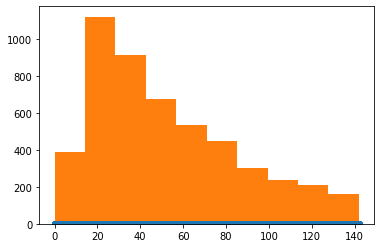

In [56]:
import numpy as np
import scipy.stats as stats
import pylab as pl
h = sorted([len(sentence) for sentence in totalX])
maxLength = h[int(len(h) * 0.60)]
print("Max length is: ",h[len(h)-1])
print("60% cover length up to: ",maxLength)
h = h[:5000]
fit = stats.norm.pdf(h, np.mean(h), np.std(h))  #this is a fitting indeed

pl.plot(h,fit,'-o')
pl.hist(h,normed=True)      #use this to draw histogram of your data
pl.show() 

## Words to number tokens, padding
Pad input sequence to max input length if it is shorter


Save the input tokenizer, since we need to use the same tokenizer for our new predition data.

In [57]:
totalX = [" ".join(wordslist) for wordslist in totalX]  # Keras Tokenizer expect the words tokens to be seperated by space 
input_tokenizer = Tokenizer(30000) # Initial vocab size
input_tokenizer.fit_on_texts(totalX)
vocab_size = len(input_tokenizer.word_index) + 1
print("input vocab_size:",vocab_size)
totalX = np.array(pad_sequences(input_tokenizer.texts_to_sequences(totalX), maxlen=maxLength))
__pickleStuff("./data/input_tokenizer_chinese.p", input_tokenizer)

input vocab_size: 22123


## Output, array of 0s and 1s

In [58]:
target_tokenizer = Tokenizer(3)
target_tokenizer.fit_on_texts(totalY)
print("output vocab_size:",len(target_tokenizer.word_index) + 1)
totalY = np.array(target_tokenizer.texts_to_sequences(totalY)) -1
totalY = totalY.reshape(totalY.shape[0])

output vocab_size: 3


In [14]:
totalY[40:50]

array([0, 0, 1, 1, 1, 1, 0, 0, 0, 1])

## Turn output 0s and 1s to categories(one-hot vectors)

In [59]:
totalY = to_categorical(totalY, num_classes=2)

In [60]:
totalY[40:50]

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [61]:
output_dimen = totalY.shape[1] # which is 2

## Save meta data for later predition
maxLength: the input sequence length

vocab_size: Input vocab size

output_dimen: which is 2 in this example (pos or neg)

sentiment_tag: either ["neg","pos"] or ["pos","neg"] matching the target tokenizer

In [62]:
target_reverse_word_index = {v: k for k, v in list(target_tokenizer.word_index.items())}
sentiment_tag = [target_reverse_word_index[1],target_reverse_word_index[2]] 
metaData = {"maxLength":maxLength,"vocab_size":vocab_size,"output_dimen":output_dimen,"sentiment_tag":sentiment_tag}
__pickleStuff("./data/meta_sentiment_chinese.p", metaData)

## Build the Model, train and save it
The training data is logged to Tensorboard, we can look at it by cd into directory 

"./Graph/sentiment_chinese" and run


"python -m tensorflow.tensorboard --logdir=."

In [63]:
embedding_dim = 256

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim,input_length = maxLength))
# Each input would have a size of (maxLength x 256) and each of these 256 sized vectors are fed into the GRU layer one at a time.
# All the intermediate outputs are collected and then passed on to the second GRU layer.
model.add(GRU(256, dropout=0.9, return_sequences=True))
# Using the intermediate outputs, we pass them to another GRU layer and collect the final output only this time
model.add(GRU(256, dropout=0.9))
# The output is then sent to a fully connected layer that would give us our final output_dim classes
model.add(Dense(output_dimen, activation='softmax'))
# We use the adam optimizer instead of standard SGD since it converges much faster
tbCallBack = TensorBoard(log_dir='./Graph/sentiment_chinese', histogram_freq=0,
                            write_graph=True, write_images=True)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
model.fit(totalX, totalY, validation_split=0.1, batch_size=32, epochs=20, verbose=1, callbacks=[tbCallBack])
model.save('./data/sentiment_chinese_model.HDF5')

print("Saved model!")

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 68, 256)           5663488   
                                                                 
 gru_12 (GRU)                (None, 68, 256)           393984    
                                                                 
 gru_13 (GRU)                (None, 256)               393984    
                                                                 
 dense_6 (Dense)             (None, 2)                 514       
                                                                 
Total params: 6,451,970
Trainable params: 6,451,970
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20


167/167 [==============================] - 88s 508ms/step - loss: 0.6163 - accuracy: 0.6403 - val_loss: 0.4586 - val_accuracy: 0.8074
Epoch 2/20
167/167 [==============================] - 82s 494ms/step - loss: 0.4287 - accuracy: 0.8129 - val_loss: 0.3343 - val_accuracy: 0.8615
Epoch 3/20
167/167 [==============================] - 83s 495ms/step - loss: 0.3035 - accuracy: 0.8768 - val_loss: 0.3164 - val_accuracy: 0.8699
Epoch 4/20
167/167 [==============================] - 83s 497ms/step - loss: 0.2573 - accuracy: 0.9001 - val_loss: 0.3041 - val_accuracy: 0.8767
Epoch 5/20
167/167 [==============================] - 83s 500ms/step - loss: 0.2049 - accuracy: 0.9228 - val_loss: 0.3087 - val_accuracy: 0.8818
Epoch 6/20
167/167 [==============================] - 83s 498ms/step - loss: 0.1708 - accuracy: 0.9378 - val_loss: 0.3691 - val_accuracy: 0.8868
Epoch 7/20
167/167 [==============================] - 83s 498ms/step - loss: 0.1469 - accuracy: 0.9440 - val_loss: 0.2935 - val_accuracy: 0.8

INFO:tensorflow:Assets written to: ./data/sentiment_chinese_model.HDF5\assets


Saved model!


### Below are prediction code
Function to load the meta data and the model we just trained.

In [64]:
model = None
sentiment_tag = None
maxLength = None
def loadModel():
    global model, sentiment_tag, maxLength
    metaData = __loadStuff("./data/meta_sentiment_chinese.p")
    maxLength = metaData.get("maxLength")
    vocab_size = metaData.get("vocab_size")
    output_dimen = metaData.get("output_dimen")
    sentiment_tag = metaData.get("sentiment_tag")
    embedding_dim = 256
    if model is None:
        model = Sequential()
        model.add(Embedding(vocab_size, embedding_dim, input_length=maxLength))
        # Each input would have a size of (maxLength x 256) and each of these 256 sized vectors are fed into the GRU layer one at a time.
        # All the intermediate outputs are collected and then passed on to the second GRU layer.
        model.add(GRU(256, dropout=0.9, return_sequences=True))
        # Using the intermediate outputs, we pass them to another GRU layer and collect the final output only this time
        model.add(GRU(256, dropout=0.9))
        # The output is then sent to a fully connected layer that would give us our final output_dim classes
        model.add(Dense(output_dimen, activation='softmax'))
        # We use the adam optimizer instead of standard SGD since it converges much faster
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        model.load_weights('./data/sentiment_chinese_model.HDF5/variables/variables')
        #model.load_weights('/Users/tanmingxin/Desktop/Chinese_sentiment_analysis-master/data/sentiment_chinese_model.HDF5')
        model.summary()
    print("Model weights loaded!")

## Functions to convert sentence to model input, and predict result

In [65]:
def findFeatures(text):
    text=Converter('zh-hans').convert(text)
    text = text.replace("\n", "")
    text = text.replace("\r", "") 
    seg_list = jieba.cut(text, cut_all=False)
    seg_list = list(seg_list)
    text = " ".join(seg_list)
    textArray = [text]
    input_tokenizer_load = __loadStuff("./data/input_tokenizer_chinese.p")
    textArray = np.array(pad_sequences(input_tokenizer_load.texts_to_sequences(textArray), maxlen=maxLength))
    return textArray
def predictResult(text):
    if model is None:
        print("Please run \"loadModel\" first.")
        return None
    features = findFeatures(text)
    predicted = model.predict(features)[0] # we have only one sentence to predict, so take index 0
    predicted = np.array(predicted)
    probab = predicted.max()
    predition = sentiment_tag[predicted.argmax()]
    return predition, probab

## Calling the load model function

In [66]:
loadModel()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 68, 256)           5663488   
                                                                 
 gru_14 (GRU)                (None, 68, 256)           393984    
                                                                 
 gru_15 (GRU)                (None, 256)               393984    
                                                                 
 dense_7 (Dense)             (None, 2)                 514       
                                                                 
Total params: 6,451,970
Trainable params: 6,451,970
Non-trainable params: 0
_________________________________________________________________
Model weights loaded!


## Try some new comments, feel free to try your own
The result tuple consists the predicted result and likehood.

In [76]:
predictResult("不会再来了。")

('neg', 0.88785654)

In [68]:
predictResult("床上有污渍，房间太挤不透气，空调不怎么好用。")

('neg', 0.8622959)

In [69]:
predictResult("房间有点小但是设备还齐全，没有异味。")

('pos', 0.9061275)

In [70]:
predictResult("房间还算干净，一般般吧，短住还凑合。")

('neg', 0.9240764)

In [71]:
predictResult("开始不太满意，前台好说话换了一间，房间很干净没有异味。")

('neg', 0.6010793)

In [72]:
predictResult("不需要。")

('neg', 0.6878349)

In [75]:
predictResult("服务态度极其差，前台接待好象没有受过培训，连基本的礼貌都不懂，竟然同时接待几个客人；")

('neg', 0.9964706)